In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
from functools import reduce

from pyspark.sql import SparkSession, DataFrame

In [2]:
sp = SparkSession.builder.appName("Fraud detection").getOrCreate()

22/09/14 21:48:35 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.27.73.57 instead (on interface eth0)
22/09/14 21:48:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/14 21:48:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sp

In [12]:
def merge_folder(trans_group: str):
    """
    Function to merge everything within yellow or green or fhvhv
    """
    dir = "../data/tables/" + trans_group +"/"
    folder_locs = os.listdir(dir)

    group_list = []
    for folder in folder_locs:
        path = dir + "/" + folder
        if os.path.isdir(path):
            # print("At current path", path)
            group_list.append(sp.read.parquet(path))

    return reduce(DataFrame.unionAll, group_list)

In [13]:
dir = "../data/tables/"
groups = ["transactions_20210228_20210827_snapshot/", "transactions_20210828_20220227_snapshot/", "transactions_20220228_20220828_snapshot/"]

final_list = []
for g in groups:
    print("Started group: ", g)
    final_list.append(merge_folder(g))

final = reduce(DataFrame.unionAll, final_list)

Started group:  transactions_20210228_20210827_snapshot/
Started group:  transactions_20210828_20220227_snapshot/
Started group:  transactions_20220228_20220828_snapshot/


In [14]:
final.count()

14195505

In [15]:
# To make it faster to visualize
sample = final.sample(0.01)
sample.show(5)
sample.count()

+-------+------------+------------------+--------------------+
|user_id|merchant_abn|      dollar_value|            order_id|
+-------+------------+------------------+--------------------+
|  18564| 21772962346|  464.259048143911|3935102f-bcd1-478...|
|    119| 24715277505| 35.74337088086195|fdfc8872-6392-4a8...|
|  18629| 19933438190| 8.613623206192926|a04563c8-1254-47f...|
|  18639| 43073797016| 206.7626907627977|e349f647-4313-474...|
|  18818| 24852446429|13.281398790574173|e72107af-95a8-42f...|
+-------+------------+------------------+--------------------+
only showing top 5 rows



141823

In [19]:
cFraud = sp.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
cFraud.show(3)
cFraud.count()

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
+-------+--------------+-----------------+
only showing top 3 rows



34864

In [20]:
mFraud = sp.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
mFraud.show(3)
mFraud.count()

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
+------------+--------------+------------------+
only showing top 3 rows



114

22/09/15 00:43:27 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 7406266 ms exceeds timeout 120000 ms
22/09/15 00:43:28 WARN SparkContext: Killing executors is not supported by current scheduler.


In [21]:
customer_fraud = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
customer_fraud.head()

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425


In [23]:
sample.select("user_id").distinct().count()

22/09/15 03:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1117.1 KiB


24019

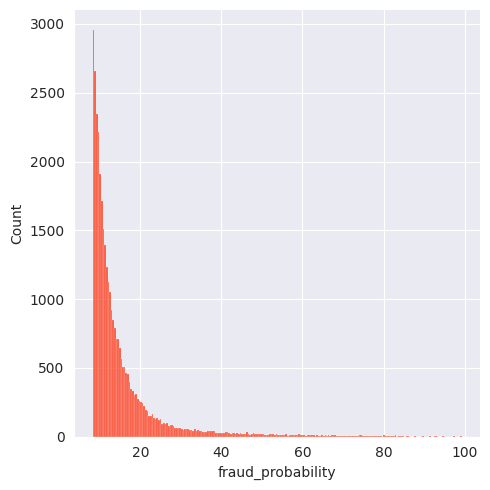

In [25]:
sns.set_style("darkgrid")
sns.set_palette("autumn")

sns.displot(customer_fraud["fraud_probability"])

In [31]:
customer_fraud[customer_fraud["fraud_probability"] > 33.33].count()

user_id              1862
order_datetime       1862
fraud_probability    1862
dtype: int64

In [27]:
customer_fraud.count()

user_id              34864
order_datetime       34864
fraud_probability    34864
dtype: int64

In [32]:
merchant_fraud = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud.head()

,merchant_abn,order_datetime,fraud_probability
0,19492220327,2021-11-28,44.403659
1,31334588839,2021-10-02,42.755301
2,19492220327,2021-12-22,38.867790
3,82999039227,2021-12-19,94.134700
4,90918180829,2021-09-02,43.325517


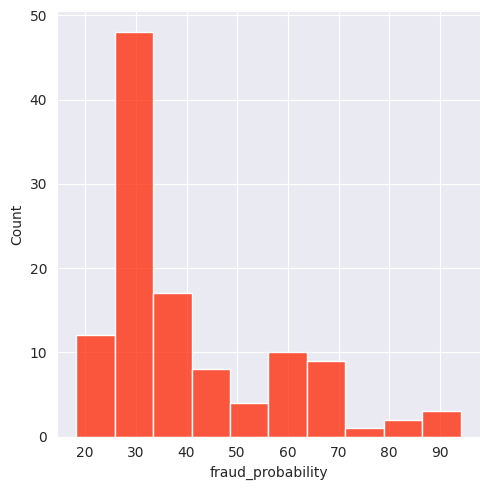

In [33]:
sns.displot(merchant_fraud["fraud_probability"])

In [34]:
merchant_fraud[merchant_fraud["fraud_probability"] < 20].count()

merchant_abn         2
order_datetime       2
fraud_probability    2
dtype: int64

In [35]:
merchant_fraud.count()

merchant_abn         114
order_datetime       114
fraud_probability    114
dtype: int64

In [36]:
merchant_fraud[merchant_fraud["fraud_probability"] > 50].count()

merchant_abn         27
order_datetime       27
fraud_probability    27
dtype: int64